Transfer Learning:

Transfer learning is a technique used in deep learning by using the pretrained model for training on a new dataset instead of starting from scratch.

In [1]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np


In [2]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly


dset = DatasetFolder(root='RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

In [3]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)



In [4]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

resnet_no_weights = models.resnet18() # from neaclass1
resnet_weights = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1) # Used Resnet weights trained on ImageNet1k from neaclass2


In [5]:
layers = list(resnet_no_weights.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
layers.append(nn.Linear(512,6))
no_weights_resnet = nn.Sequential(*layers)

layers = list(resnet_weights.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
layers.append(nn.Linear(512,6))
weights_resnet = nn.Sequential(*layers)



TRAINING RESNET MODEL without Weights of IMAGENET

In [6]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
no_weights_resnet = no_weights_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(no_weights_resnet.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

N_EPOCHS = 20
tr_loss_hist_1 = []
val_loss_hist_1 = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    no_weights_resnet.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = no_weights_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    no_weights_resnet.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = no_weights_resnet(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist_1.append(train_loss/len(trainloader))
    val_loss_hist_1.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.1649748257795969 Val Loss: 1.9711449789373499
Epoch: 1 Train Loss: 0.6779052193959554 Val Loss: 1.9672244991126813
Epoch: 2 Train Loss: 0.6005096785227457 Val Loss: 3.4849837814506732
Epoch: 3 Train Loss: 0.504300338625908 Val Loss: 1.1030557963408922
Epoch: 4 Train Loss: 0.38896421844760576 Val Loss: 0.4333693500804274
Epoch: 5 Train Loss: 0.342341115574042 Val Loss: 1.3337470677338148
Epoch: 6 Train Loss: 0.3417145412166913 Val Loss: 1.222364911123326
Epoch: 7 Train Loss: 0.2915828287104766 Val Loss: 0.2759524109332185
Epoch: 8 Train Loss: 0.30257884194453555 Val Loss: 0.477156295588142
Epoch: 9 Train Loss: 0.2695727508266767 Val Loss: 0.3967246275983359
Epoch: 10 Train Loss: 0.2534322832028071 Val Loss: 0.2281013944823491
Epoch: 11 Train Loss: 0.27393598333001135 Val Loss: 0.43004673052775233
Epoch: 12 Train Loss: 0.1799804823100567 Val Loss: 0.25489262030705023
Epoch: 13 Train Loss: 0.1892592350890239 Val Loss: 0.12669481846847033
Epoch: 14 Train Loss: 0.1635

Test Accuracy of non weighted Resnet: 0.859375


Text(0.5, 1.0, 'Loss Curves Non weighted model without scheduler')

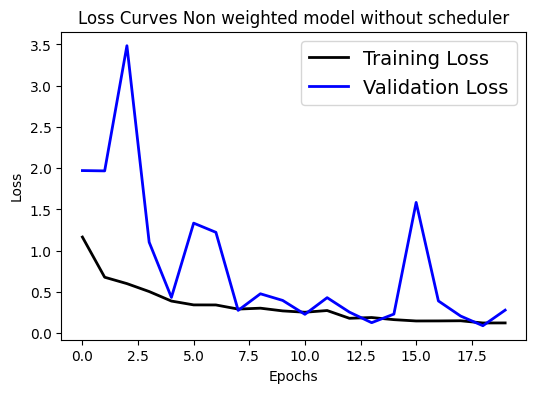

In [7]:
tset = DatasetFolder(root='RowanDLclassNEA/NEUdata_split/Test', loader = load_image, extensions = ('.bmp',), transform = transform)

testloader = torch.utils.data.DataLoader(
                    tset, 
                    batch_size=16, 
                    shuffle=True)

num_correct = 0.0

for x_test_batch, y_test_batch in testloader:

    no_weights_resnet.eval()

    y_test_batch = y_test_batch.to(device)

    x_test_batch = x_test_batch.to(device)

    y_pred_batch = no_weights_resnet(x_test_batch)

    _, predicted = torch.max(y_pred_batch, 1)

    num_correct += (predicted == y_test_batch).float().sum()

accuracy_1 = num_correct/(len(testloader)*testloader.batch_size)

print("Test Accuracy of non weighted Resnet: {}".format(accuracy_1))
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist_1, 'black', linewidth=2.0)
plt.plot(val_loss_hist_1, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves Non weighted model without scheduler', fontsize=12)

In [8]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
no_weights_resnet_scheduler = no_weights_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(no_weights_resnet.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.5, total_iters=20)

N_EPOCHS = 20
tr_loss_hist_3 = []
val_loss_hist_3 = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    no_weights_resnet.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = no_weights_resnet_scheduler(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        train_loss += loss.item()

    scheduler.step()

    # Validation
    val_loss = 0.0
    no_weights_resnet_scheduler.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = no_weights_resnet_scheduler(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist_3.append(train_loss/len(trainloader))
    val_loss_hist_3.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.09313512499133746 Val Loss: 0.08554757369290057
Epoch: 1 Train Loss: 0.0787237302151819 Val Loss: 0.1058610061391894
Epoch: 2 Train Loss: 0.08178249958902598 Val Loss: 0.07075560542656795
Epoch: 3 Train Loss: 0.06579493375495077 Val Loss: 0.13802919980432643
Epoch: 4 Train Loss: 0.06248184963439902 Val Loss: 0.04642294836230576
Epoch: 5 Train Loss: 0.058843092399959766 Val Loss: 0.045422362427129166
Epoch: 6 Train Loss: 0.06716102388687432 Val Loss: 0.271508427336812
Epoch: 7 Train Loss: 0.07445001473029454 Val Loss: 0.08066198817993465
Epoch: 8 Train Loss: 0.05815212552435696 Val Loss: 0.03449359166705491
Epoch: 9 Train Loss: 0.049618281985943515 Val Loss: 0.04921242170109365
Epoch: 10 Train Loss: 0.07632521685833732 Val Loss: 0.126276643052207
Epoch: 11 Train Loss: 0.05673218579962849 Val Loss: 0.11717058541743379
Epoch: 12 Train Loss: 0.05329893205935756 Val Loss: 0.039152288533698176
Epoch: 13 Train Loss: 0.059262126966690025 Val Loss: 0.05550023588952363
Epo

Test Accuracy of weighted resnet: 0.9375


Text(0.5, 1.0, 'Loss Curves non Weighted scheduler')

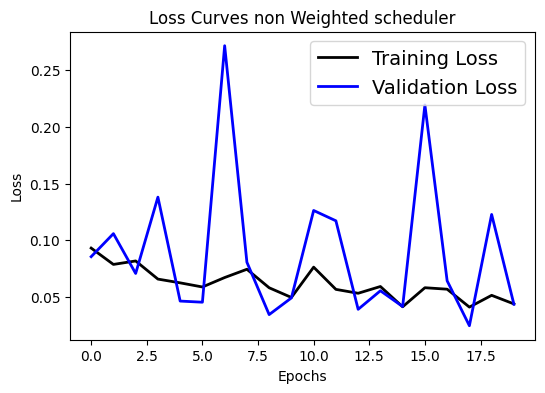

In [11]:

num_correct = 0.0

for x_test_batch, y_test_batch in testloader:

    no_weights_resnet_scheduler.eval()

    y_test_batch = y_test_batch.to(device)

    x_test_batch = x_test_batch.to(device)

    y_pred_batch = no_weights_resnet_scheduler(x_test_batch)

    _, predicted = torch.max(y_pred_batch, 1)

    num_correct += (predicted == y_test_batch).float().sum()

accuracy_2 = num_correct/(len(testloader)*testloader.batch_size)

print("Test Accuracy of weighted resnet: {}".format(accuracy_2))
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist_3, 'black', linewidth=2.0)
plt.plot(val_loss_hist_3, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves non Weighted scheduler', fontsize=12)

In [9]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
weights_resnet = weights_resnet.to(device)

optimizer = optim.SGD(weights_resnet.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


N_EPOCHS = 20
tr_loss_hist_2 = []
val_loss_hist_2 = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    weights_resnet.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = weights_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        train_loss += loss.item()
    scheduler.step()

    # Validation
    val_loss = 0.0
    weights_resnet.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = weights_resnet(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist_2.append(train_loss/len(trainloader))
    val_loss_hist_2.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.9417616033554077 Val Loss: 0.29510781953209325
Epoch: 1 Train Loss: 0.26701304684082666 Val Loss: 0.11207599496763003
Epoch: 2 Train Loss: 0.14897791554530462 Val Loss: 0.0648417125799154
Epoch: 3 Train Loss: 0.10775278945763905 Val Loss: 0.04671837703177804
Epoch: 4 Train Loss: 0.10155535124242306 Val Loss: 0.043091982676598584
Epoch: 5 Train Loss: 0.06788115029533705 Val Loss: 0.026073227526227895
Epoch: 6 Train Loss: 0.07103661434104046 Val Loss: 0.027993489301910524
Epoch: 7 Train Loss: 0.043279552478343246 Val Loss: 0.017963586767253122
Epoch: 8 Train Loss: 0.058525675274431706 Val Loss: 0.015003319180227424
Epoch: 9 Train Loss: 0.034946824951718254 Val Loss: 0.013177253747064816
Epoch: 10 Train Loss: 0.036266391612589356 Val Loss: 0.0131847520334352
Epoch: 11 Train Loss: 0.038157205792764826 Val Loss: 0.009622587221919707
Epoch: 12 Train Loss: 0.030302579601605734 Val Loss: 0.011664731547506036
Epoch: 13 Train Loss: 0.023147561773657798 Val Loss: 0.00704484

Test Accuracy of weighted resnet: 0.9375


Text(0.5, 1.0, 'Loss Curves Weighted model')

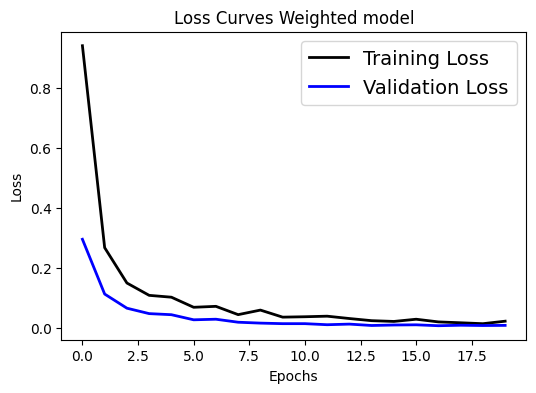

In [10]:

num_correct = 0.0

for x_test_batch, y_test_batch in testloader:

    weights_resnet.eval()

    y_test_batch = y_test_batch.to(device)

    x_test_batch = x_test_batch.to(device)

    y_pred_batch = weights_resnet(x_test_batch)

    _, predicted = torch.max(y_pred_batch, 1)

    num_correct += (predicted == y_test_batch).float().sum()

accuracy_2 = num_correct/(len(testloader)*testloader.batch_size)

print("Test Accuracy of weighted resnet: {}".format(accuracy_2))
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist_2, 'black', linewidth=2.0)
plt.plot(val_loss_hist_2, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves Weighted model', fontsize=12)